<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter10/corwd_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -U scipy torch_snippets torch_summary
    !git clone https://github.com/sizhky/CSRNet-pytorch.git
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    print('downloading data...')
    !kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
    print('unzipping data...')
    !unzip -qq shanghaitech-with-people-density-map.zip

%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 44.3 MB/s 
     |████████████████████████████████| 10.1 MB 44.5 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


Saving kaggle.json to kaggle (1).json
kaggle.json
downloading data...
100% 4.77G/4.79G [01:27<00:00, 44.9MB/s]
100% 4.79G/4.79G [01:27<00:00, 58.9MB/s]
unzipping data...
/content/CSRNet-pytorch
CPU times: user 4.43 s, sys: 1.84 s, total: 6.26 s
Wall time: 4min 56s


In [ ]:
part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = '/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/*'
heatmap_folder = '/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = '/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

2021-11-06 11:25:39.920 | INFO     | torch_snippets.paths:inner:24 - 3 files found at shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/


In [ ]:
import sys
sys.setrecursionlimit(10000)
import glob

In [ ]:
def find(test,gt_path=True):
  idx = test.find('IMG')
  img= test[idx:-4]
  if gt_path:
    gt = gt_folder+'GT_'+img+'.mat'
    return gt
  else :
    ht =heatmap_folder+img+'.h5'
    return ht

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = _stem
        print(_stem)
        heatmap_path = find(_stem,False)
        gt_path = find(_stem)

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(glob.glob(image_folder), random_state=10,test_size=0.25,train_size=0.75)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [ ]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
EPOCH: 3.520	trn_loss: 0.012	trn_pts_loss: 270.191	(856.26s - 4008.86s remaining)/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_34.jpg
EPOCH: 3.524	trn_loss: 0.135	trn_pts_loss: 390.186	(857.69s - 4009.39s remaining)/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_241.jpg
EPOCH: 3.529	trn_loss: 0.000	trn_pts_loss: 61.055	(859.03s - 4009.54s remaining)/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_286.jpg
EPOCH: 3.533	trn_loss: 0.001	trn_pts_loss: 50.485	(859.85s - 4007.21s remaining)/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_133.jpg
EPOCH: 3.538	trn_loss: 0.005	trn_pts_loss: 83.458	(861.09s - 4006.87s remaining)/content/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/IMG_126.jpg
EPOCH: 3.542	trn_loss: 0.006	trn_pts_loss

In [ ]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)
img = transform(Image.open(test_folder).convert('RGB')).to(device)

2021-11-06 13:02:05.883 | INFO     | torch_snippets.paths:inner:24 - 182 files found at shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data//images


shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_17.jpg


In [ ]:
m = nn.MaxPool2d(2, stride=2)

Predicted Count :  1


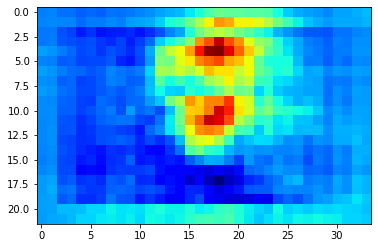

In [ ]:
output = model(img[None])
print("Predicted Count : ",int(m(output).detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()